# Nearest Neighbors

Nearst neighbor method is a nonparametric method used to density estimation that make few assumptions about the form of the distributions.



In [1]:
import jax
import jax.numpy as jnp 
import numpy as np 
from sklearn.datasets import make_classification
from sklearn.datasets import make_multilabel_classification
import matplotlib.pyplot as plt 

from basic.neighbors import NearestNeighborsDensity
from basic.neighbors import NearestNeighborsClassifier


## Frequentis Density Estimation

The density can be estimated based on the simple frequentist methods, such as 
- Histogram
- Kernel Density Estimation
- K-Nearest Neighbors

Note nonparametric Bayesian methods such as Gaussian Process can also be used for density estimation, but we will not cover it here.

Using a single continuous variable $x$ an example, standard histogram methods simply partition data $x$ into distinct bins of width $\Delta_i$ and then count the number of data points $n_i$ in each bin. The density is then estimated as

$$
p(x) = \frac{n_i}{N\Delta_i}
$$

where $N$ is the total number of data points. This is a normalized histogram. 
It is easy to see that $\int p(x)dx = 1$. This gives a model for the density $p(x)$ that is constant over the width of each bin, and often the bins are chosen to have the same width $\Delta_i = \Delta$.

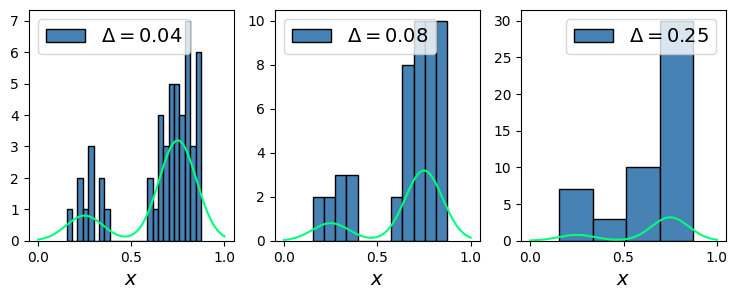

In [7]:
# define a mixture of two Gaussians
means = [0.25, 0.75]
stds = [0.1, 0.1]
ratio = [0.2, 0.8]

x_space = jnp.linspace(0, 1, 1000)
    
gaussian0 = jax.scipy.stats.norm.pdf(x_space, means[0], stds[0])
gaussian1 = jax.scipy.stats.norm.pdf(x_space, means[1], stds[1])

y_space = ratio[0] * gaussian0 + ratio[1] * gaussian1

# sample N points from the mixture
N = 50 
N1 = int(N * ratio[0])
N2 = int(N * ratio[1])

sampled_points = jnp.concatenate([jax.random.normal(jax.random.PRNGKey(47), shape=(N1,)) * stds[0] + means[0],  
                                  jax.random.normal(jax.random.PRNGKey(47), shape=(N2,)) * stds[1] + means[1]])
plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
delta = 0.04
plt.plot(x_space, y_space, color="springgreen")
plt.hist(sampled_points, bins=int(1/delta), edgecolor="black", color="steelblue", label="$\\Delta=0.04$")
plt.xlabel("$x$", fontsize=14)
plt.legend(fontsize=14)

plt.subplot(1, 3, 2)
delta = 0.08
plt.plot(x_space, y_space, color="springgreen")
plt.hist(sampled_points, bins=int(1/delta), edgecolor="black", color="steelblue", label="$\\Delta=0.08$")
plt.xlabel("$x$", fontsize=14)
plt.legend(fontsize=14)

plt.subplot(1, 3, 3)
delta = 0.25
plt.plot(x_space, y_space, color="springgreen")
plt.hist(sampled_points, bins=int(1/delta), edgecolor="black", color="steelblue", label="$\\Delta=0.25$")
plt.xlabel("$x$", fontsize=14)
plt.legend(fontsize=14)

plt.show()                             

## Kernel Density Estimator

Now, suppose that observations are being drawn from an unknown probability density function $p(\mathbf{x})$ in a D-dimensional Euclidean space. 
Let's cosnider a small local region $\mathcal{R}$ containing $\mathbf{x}$.
Then, the probability mass of this region is given by

$$
P_{\mathcal{R}} = \int_{\mathcal{R}} p(\mathbf{x})d\mathbf{x}
$$

hen, given a data set comprising $N$ observations drawn from $p(\mathbf{x})$, each data point has a probability $P_{\mathcal{R}}$ of falling into the region $\mathcal{R}$. Thus, in general, the total number $K$ of points out of $N$, that lie inside $\mathcal{R}$ are distributed according to a binomial distribution 

$$
Bin(K|N, P_{\mathcal{R}}) = \binom{N}{K}P_{\mathcal{R}}^K(1-P_{\mathcal{R}})^{N-K}
$$

Following the Bernoulli distribution properties, the expected value of $K$ points out of $N$ falling into $\mathcal{R}$ is given by 

$$
\mathbb{E}[K/N] = P_{\mathcal{R}}
$$

and the variance is given by 

$$
var[K/N] = \frac{P_{\mathcal{R}}(1-P_{\mathcal{R}})}{N}
$$

Assuming a large $N$, variance is going to shrink and the distribution is going to be sharply peaked around the mean, leading to a $P_{\mathcal{R}}$ proportion of $N$ points (that is, $K$) to be located inside $\mathcal{R}$.

$$
K \approx N P_{\mathcal{R}}
$$

Furthermore, assumming the region is small enough that the density $p(\mathbf{x})$ can be considered constant over the region, then the probability mass $P_{\mathcal{R}}$ is given by

$$
P_{\mathcal{R}} \approx p(\mathbf{x}) V_{\mathcal{R}}
$$
where $V_{\mathcal{R}}$ is the volume of the region $\mathcal{R}$.

Combining the above two assumptions, we obtain a density estimation in the form:

$$
p(\mathbf{x}) \approx \frac{K}{NV_{\mathcal{R}}}
$$

Note that the validity of the density depends on two **contradictory assumptions**, namely that the region $\mathcal{R}$ is sufficiently small that the density is approximately constant over the region and yet sufficiently large (in relation to the value of that density) that the number $K$ of points falling inside the region is sufficient for the binomial distribution to be sharply peaked.

We can exploit the resulted density in two different ways:

1. Assume a $V$ and determine $K$ from the data, giving rise to the kernel approach
2. Assume a $K$ and determine the value of $V$ from the data, giving rise to the $k$-nearest neighbour technique. 

## Nearest Neighbor Estimator

Nearest neighbor method assumes a fixed $K$ and determines the value of $V$ from the data based on distance.

We consider a small sphere centered on the point $\mathbf{x}$ at which we wish to estimate the density. 
Then we allow the radius grow until it contains precisely $K$ data points. 
The volume of an Euclidean ball of radius $r$ in $D$ dimensions is given by:

$$
V = \frac{\pi^{D/2}}{\Gamma(D/2+1)}r^D
$$

where $\Gamma(\cdot)$ is the gamma function.

The density is then estimated as:

$$
p(\mathbf{x}) = \frac{K}{NV}
$$


(1000, 50)
(1000, 50)
(1000, 50)


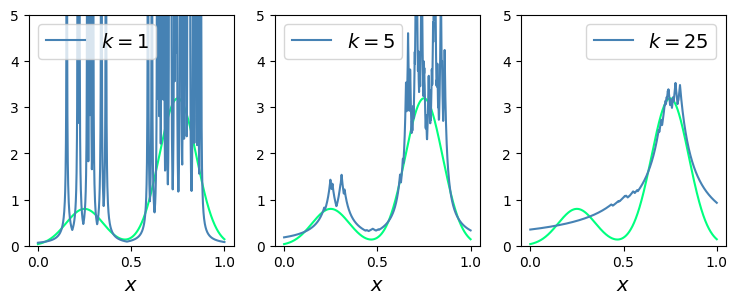

In [11]:
model = NearestNeighborsDensity()

plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.plot(x_space, y_space, color="springgreen")
density = model.predict(sampled_points.reshape(-1,1), x_space.reshape(-1,1), k=1)
plt.plot(x_space, density, color="steelblue", label="$k=1$")
plt.xlabel("$x$", fontsize=14)
plt.ylim(0, 5)
plt.legend(fontsize=14)

plt.subplot(1, 3, 2)
plt.plot(x_space, y_space, color="springgreen")
density = model.predict(sampled_points.reshape(-1,1), x_space.reshape(-1,1), k=5)
plt.plot(x_space, density, color="steelblue", label="$k=5$")
plt.xlabel("$x$", fontsize=14)
plt.ylim(0, 5)
plt.legend(fontsize=14)

plt.subplot(1, 3, 3)
plt.plot(x_space, y_space, color="springgreen")
density = model.predict(sampled_points.reshape(-1,1), x_space.reshape(-1,1), k=25)
plt.plot(x_space, density, color="steelblue", label="$k=25$")
plt.xlabel("$x$", fontsize=14)
plt.ylim(0, 5)
plt.legend(fontsize=14)

plt.show()

We see that the value of K now governs the degree of smoothing and that again there is an optimum choice for K that is neither too large nor too small. Note that the model produced by K nearest neighbours is not a true density model because the integral over all space diverges.

$K$-NN can also be used for classificiations. The idea is to find the k nearest neighbors and assign the class label by majority vote. The following example shows how to use k-NN for classification.
To do so, we do the followings:
1. apply $K$-NN density estimation techinque to each class separately for evaluating class-conditional densities $p(\mathbf{x} | \mathcal{C}_k)$. Let's assume we have a dataset compromising $N_k$ points in class $\mathcal{C}_k$ with N points in total, so that $\sum_k N_k = N$.
If we wish to classfy a new data point $\mathbf{x}$, we draw a sphere centered on $\mathbf{x}$ and grow the radius until it contains precisely $K$ points. 
Suppose the sphere has a volumne of $V$, and contains $K_k$ points from class $\mathcal{C}_k$.
Based on previous discussion, we know the class-conditional density can be estimated as:
    $$
    p(\mathbf{x} | \mathcal{C}_k) = \frac{K_k}{N_kV}
    $$

2. infer the prior class probabilities $p(\mathcal{C}_k)$ from the training data,
    $$
    p(\mathcal{C}_k) = \frac{N_k}{N}
    $$
3. infer the unconditional density of $\mathbf{x}$:
    $$
    p(\mathbf{x}) = \frac{K}{NV}
    $$

4. use Bayes' rule to get the posterior class probabilities $p(\mathcal{C}_k | \mathbf{x})$ by

    $$
    p(\mathcal{C}_k | \mathbf{x}) = \frac{p(\mathbf{x} | \mathcal{C}_k)p(\mathcal{C}_k)}{p(\mathbf{x})} = \frac{K_k}{K}
    $$

Text(0.5, 1.0, '$K=11$')

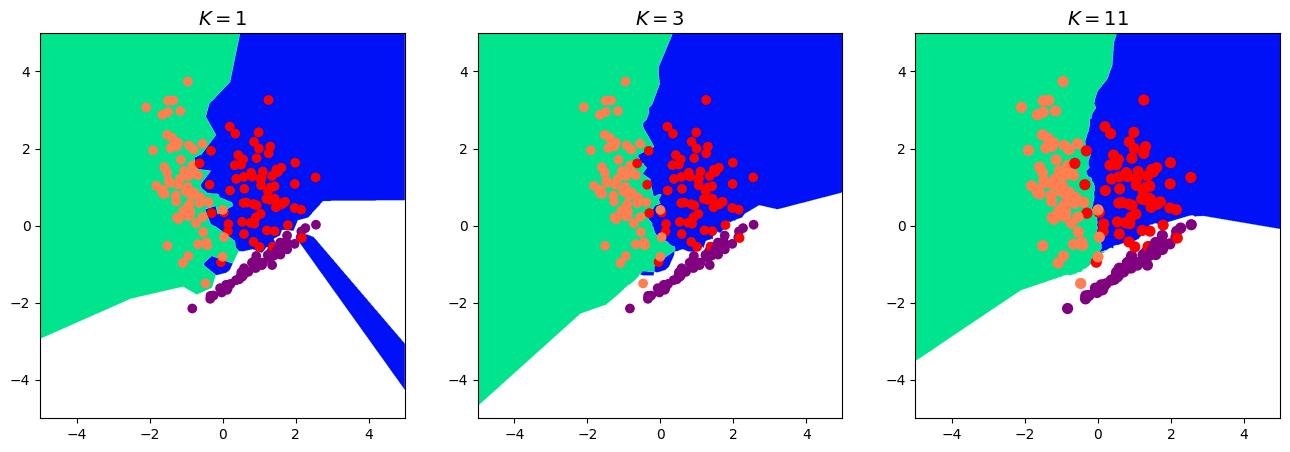

In [12]:
N = 200
D = 2

x, t = make_classification(n_samples=N, 
                            n_features=D, 
                            n_informative=D, 
                            n_redundant=0, 
                            n_repeated=0, 
                            n_classes=3, 
                            n_clusters_per_class=1,
                            random_state=44)
x = jnp.array(x)
t = jnp.array(t)

x_space = jnp.arange(-5, 5, 0.01)
x1, x2 = jnp.meshgrid(x_space, x_space)
x_hat = jnp.vstack((x1.ravel(), x2.ravel())).T

class_colors = []
for i in range(t.shape[0]):
    if t[i] == 0:
        color = "red"
    elif t[i] == 1:
        color = "coral"
    else:
        color = "purple"
    class_colors.append(color)

plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
model = NearestNeighborsClassifier()
Z, _, _ = model.predict(x, t, x_hat, k=1)
Z = Z.reshape(-1, 1)

plt.contourf(
    x_space, x_space, Z[:, 0].reshape(x1.shape), cmap="winter", levels=np.arange(-0.1, 1.1, 0.05), antialiased=True
)
plt.scatter(x[:, 0], x[:, 1], color=class_colors)
plt.title("$K=1$", fontsize=14)

plt.subplot(1, 3, 2)
model = NearestNeighborsClassifier()
Z, _, _ = model.predict(x, t, x_hat, k=3)
Z = Z.reshape(-1, 1)
plt.contourf(
    x_space, x_space, Z[:, 0].reshape(x1.shape), cmap="winter", levels=np.arange(-0.1, 1.1, 0.05), antialiased=True
)
plt.scatter(x[:, 0], x[:, 1], color=class_colors)
plt.title("$K=3$", fontsize=14)

plt.subplot(1, 3, 3)
model = NearestNeighborsClassifier()
Z, _, _ = model.predict(x, t, x_hat, k=11)
Z = Z.reshape(-1, 1)
plt.contourf(
    x_space, x_space, Z[:, 0].reshape(x1.shape), cmap="winter", levels=np.arange(-0.1, 1.1, 0.05), antialiased=True
)
plt.scatter(x[:, 0], x[:, 1], color=class_colors, s=50)
plt.title("$K=11$", fontsize=14)
